In [41]:
# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

## **CONFIGURACION DEL ENTORNO**

In [42]:
# AUDIO_DATA_PATH = 'data/'
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'
FEATURES_PATH = GPATH + 'SpeechEmotionRecognition/data/processed/features/'
# LPATH_AUGMENTED = GPATH + AUDIO_DATA_PATH + 'RAVDESS/augmented'

# 
SAVEE_PATH = GPATH + 'data/SAVEE/'
TESS_PATH = GPATH + 'data/TESS/'
RAVDESS_PATH = GPATH + 'data/RAVDESS/'

# Maps
EMOTION_MAP = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}

Configuramos el entorno para que nos deje acceder a los archivos e importar los módulos de python.

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import sys  
# sys.path.remove(GPATH + '/SpeechEmotionRecognition')
sys.path.insert(0, GPATH + '/SpeechEmotionRecognition')

## **1. DATOS**

### **1.1 CARGA DE LOS DATOS**

#### **1.1.1 DATASET SAVEE**

In [45]:
# Leemos SAVEE

emotion=[]
path = []

for dir in os.listdir(SAVEE_PATH):
  path_dir = os.listdir(SAVEE_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filename in path_dir:
    str_path = SAVEE_PATH + dir + '/' + str(filename)
    path.append(str_path)
    if(filename[0]=='a'):
        emotion.append("angry")
    elif(filename[0]=='h'):
        emotion.append("happy")
    elif(filename[0]=='f'):
        emotion.append("fear")
    elif(filename[0]=='d'):
        emotion.append("disgust")
    elif(filename[0]=='n'):
        emotion.append('neutral')
    elif(filename[0]=='s'):
        if(filename[1]=='a'):
            emotion.append("sad")
        elif(filename[1]=='u'):
            emotion.append("surprise")


SAVEE_df = pd.DataFrame(columns=['emotion', 'path'])
SAVEE_df['emotion'] = emotion
SAVEE_df['path'] = path

SAVEE_df['emotion'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [46]:
SAVEE_df.sample(5)

,emotion,path
326,neutral,/content/drive/My Drive/Master/Asignaturas/2 C...
345,surprise,/content/drive/My Drive/Master/Asignaturas/2 C...
336,neutral,/content/drive/My Drive/Master/Asignaturas/2 C...
343,sad,/content/drive/My Drive/Master/Asignaturas/2 C...
357,surprise,/content/drive/My Drive/Master/Asignaturas/2 C...


### **1.2 DATASET TESS**

In [47]:
# Leemos TESS

emotion=[]
path = []

for dir in os.listdir(TESS_PATH):
  path_dir = os.listdir(TESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  label = dir.split('_')[1]
  for filename in path_dir:
    str_path = TESS_PATH + dir + '/' + str(filename)
    path.append(str_path)
    emotion.append(label.lower())


TESS_df = pd.DataFrame(columns=['emotion', 'path'])
TESS_df['emotion'] = emotion
TESS_df['path'] = path

TESS_df.sample(5)

,emotion,path
151,sad,/content/drive/My Drive/Master/Asignaturas/2 C...
1301,disgust,/content/drive/My Drive/Master/Asignaturas/2 C...
93,sad,/content/drive/My Drive/Master/Asignaturas/2 C...
1718,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
1499,neutral,/content/drive/My Drive/Master/Asignaturas/2 C...


In [48]:
TESS_df['emotion'].unique()

array(['sad', 'fear', 'happy', 'neutral', 'angry', 'disgust', 'surprise'],
      dtype=object)

### **1.3 RAVDESS**

In [49]:
emotion = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in os.listdir(RAVDESS_PATH):
  path_dir = os.listdir(RAVDESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    str_path = RAVDESS_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)


# Construimos el data frame
RAVDESS_df = pd.DataFrame(columns=['emotion', 'path'])
RAVDESS_df['emotion'] = emotion
RAVDESS_df['path'] = path
RAVDESS_df['emotion'] = RAVDESS_df['emotion'].map(EMOTION_MAP) 

RAVDESS_df.sample(5)

,emotion,path
1136,surprise,/content/drive/My Drive/Master/Asignaturas/2 C...
98,angry,/content/drive/My Drive/Master/Asignaturas/2 C...
718,disgust,/content/drive/My Drive/Master/Asignaturas/2 C...
381,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
563,sad,/content/drive/My Drive/Master/Asignaturas/2 C...


In [50]:
print( "Size of the dataset: {} \n".format(len(RAVDESS_df)) )
print( RAVDESS_df['emotion'].value_counts() )

Size of the dataset: 1440 

happy       192
surprise    192
calm        192
fear        192
disgust     192
sad         192
angry       192
neutral      96
Name: emotion, dtype: int64


Para que todas las emociones coincidan con el resto de datasets, vamos a eliminar calm

In [51]:
RAVDESS_df['emotion'].unique()
RAVDESS_df = RAVDESS_df[RAVDESS_df['emotion'] != 'calm']
RAVDESS_df['emotion'].unique()

array(['neutral', 'happy', 'sad', 'angry', 'fear', 'surprise', 'disgust'],
      dtype=object)

### **1.2 EXTRACCION DE CARACTERISTICAS**

In [52]:
from src.MFCC import MFCC
# # df_data, dataset_name, outpath='', n_features=40
# featuresMFCC_SAVEE = MFCC(df_data = SAVEE_df)
# featuresSAVEE_standard, featuresSAVEE_wn, featuresSAVEE_shiftted, featuresSAVEE_pitch = featuresMFCC_SAVEE.read_features_dataAugmentation()

In [54]:
features_path = FEATURES_PATH 
if not os.path.exists(features_path + 'featuresMFCC_standard_SAVEE.pkl' and 
                      features_path + 'featuresMFCC_wn_SAVEE.pkl' and 
                      features_path +'featuresMFCC_shiftted_SAVEE.pk' and 
                      features_path + 'featuresMFCC_pitch_SAVEE.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_SAVEE = MFCC(df_data = SAVEE_df, dataset_name = 'SAVEE', outpath = features_path)
  featuresSAVEE_standard, featuresSAVEE_wn, featuresSAVEE_shiftted, featuresSAVEE_pitch = featuresMFCC_SAVEE.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_pitch = pickle.load(f)

In [55]:
# Concatenamos con las clases
datasetSAVEE = pd.concat([SAVEE_df.emotion, pd.DataFrame(featuresSAVEE_standard['data'].values.tolist())],axis=1)
datasetSAVEE.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,angry,-268.415161,102.647194,-6.831020,21.777452,5.504901,2.677995,-17.891163,-4.412988,-3.229257,0.431965,-0.299165,-2.524848,-0.071857,-4.558034,5.516014,2.072710,-1.574175,-0.609725,-5.144129,-3.185401,-1.633157,-1.973433,-0.073229,-2.811360,-0.021867,0.143352,0.961058,1.967452,-0.008761,-0.017257,-1.543826,0.943443,-0.501338,-0.080925,0.131035,-1.918740,1.268646,2.679410,2.754247,3.670862
1,angry,-244.658691,104.249260,0.657433,41.458733,-1.098887,3.049911,-23.316795,-7.371824,-7.313964,-5.459171,-5.131516,-6.225185,0.600989,-3.874696,3.832613,-0.631364,1.173085,-0.016179,-6.350923,-3.178102,-1.378558,-3.167055,0.234321,-3.861040,-3.318711,-0.789949,-0.051503,4.036880,2.849089,3.908473,2.513106,4.278307,4.096043,2.962423,3.240562,0.578125,1.794270,3.656604,4.363981,3.638849
2,angry,-457.141174,116.235977,36.340252,37.334404,2.328947,10.415856,-8.627520,-7.653417,1.220687,1.685766,2.807936,4.826628,1.932658,0.788597,8.819584,2.063912,2.408954,5.167501,-0.885871,-0.219375,1.186609,1.849909,1.388026,-2.331348,0.435481,-0.512867,0.410653,0.251607,-0.025797,1.957222,-0.307779,0.934475,-0.475870,1.687494,2.125605,-0.359137,1.364770,2.144406,3.085626,3.569379
3,angry,-441.442596,123.601067,31.101675,47.328548,10.899825,2.156022,-23.183657,-0.154049,6.429157,-0.867114,-0.026879,-0.301824,1.041199,1.111201,11.766346,1.339256,-0.321349,6.915440,-1.305079,-0.159503,2.926197,0.255705,-0.101505,-2.642427,1.411443,-1.501623,-2.327403,0.010480,-0.730455,-0.337589,-1.373045,1.433707,-0.835213,1.011121,2.115383,1.603536,2.301774,1.726071,3.415561,3.127162
4,angry,-423.768341,120.783394,34.300705,42.939449,13.812046,5.338738,-15.809108,-8.547617,0.258116,-1.198904,-0.056940,-1.199689,0.371676,2.397501,10.340876,4.918323,0.812542,1.260555,-0.975449,0.881763,3.192188,2.732885,-1.294272,-2.020182,0.421686,-2.112548,-1.400463,-1.662408,-2.011160,1.610833,0.020815,1.006315,0.947063,0.939697,1.956713,0.167548,1.582842,1.981372,1.343701,3.107995


In [58]:
# Comprobamos las dimensiones
print("SAVEE tiene {} filas y {} caracteristicas".format(datasetSAVEE.shape[0], datasetSAVEE.shape[1]-1))

SAVEE tiene 480 filas y 40 caracteristicas


In [59]:
features_path = FEATURES_PATH 
if not os.path.exists(features_path + 'featuresMFCC_standard_TESS.pkl' and 
                      features_path + 'featuresMFCC_wn_TESS.pkl' and 
                      features_path +'featuresMFCC_shiftted_TESS.pk' and 
                      features_path + 'featuresMFCC_pitch_TESS.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_TESS = MFCC(df_data = TESS_df, dataset_name = 'TESS', outpath = features_path)
  featuresTESS_standard, featuresTESS_wn, featuresTESS_shiftted, featuresTESS_pitch = featuresMFCC_TESS.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_TESS.pkl', 'rb') as f:
    featuresTESS_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_TESS.pkl', 'rb') as f:
    featuresTESS_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_TESS.pkl', 'rb') as f:
    featuresTESS_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_TESS.pkl', 'rb') as f:
    featuresTESS_pitch = pickle.load(f)

  0%|          | 0/2800 [00:00<?, ?it/s]

Los archivos no existen. Se procede a crearlos...


  0%|          | 3/2800 [00:00<01:41, 27.50it/s]

Caracteristicas estandar serializadas


  0%|          | 4/2800 [00:00<01:28, 31.77it/s]

Caracteristicas aumentadas con Ruido Blanco serializadas


  0%|          | 0/2800 [00:00<?, ?it/s]

Caracteristicas aumentadas con Desplazamiento serializadas


100%|██████████| 2800/2800 [05:26<00:00,  8.59it/s]

Caracteristicas aumentadas con Modulacion serializadas


In [60]:
# Concatenamos con sus clases
datasetTESS = pd.concat([TESS_df.emotion, pd.DataFrame(featuresTESS_standard['data'].values.tolist())],axis=1)
datasetTESS.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,sad,-551.718140,93.898018,32.626316,27.400211,12.044376,15.325372,-4.534317,4.946284,-14.656589,1.937302,-14.233812,0.943044,-12.615483,3.372640,-0.877842,-1.540113,-0.692189,3.532070,1.489519,-3.923512,0.486482,-1.894393,-5.936152,2.481138,-3.375456,0.295575,-0.353550,1.325829,-0.575355,5.283757,8.826845,11.738833,9.708747,6.377355,6.265841,-0.755742,4.269774,8.935454,10.005108,9.995243
1,sad,-531.651428,77.865715,21.592104,24.727236,13.807357,15.917933,-21.148481,-13.770829,-17.578056,9.696571,-17.848701,8.055055,-7.135981,7.949358,-1.761927,-3.226586,1.244170,4.245619,0.758662,-7.251886,6.438428,-2.463238,-4.401299,-2.140193,-7.621655,-0.759195,-2.392330,1.330557,0.698337,10.117504,9.391307,11.811658,9.762551,6.464757,6.648894,7.559505,13.014347,17.321518,13.843499,11.259350
2,sad,-531.661011,88.863670,22.462118,14.307739,4.722463,16.334551,-12.150962,-6.318793,-16.228617,8.226312,-14.295836,8.363665,-6.634265,7.822025,0.173369,-4.222826,1.851476,-1.332733,3.747557,-5.150695,2.784880,-1.588107,-3.999930,-1.678870,-5.183728,-2.521509,-0.700438,0.491303,3.090086,8.333586,8.776573,15.926026,8.943348,8.824706,7.321424,4.367829,8.087577,11.370471,11.962422,10.727288
3,sad,-522.041809,91.776588,19.694820,17.102062,11.354354,19.801527,-13.455955,-1.803107,-17.500757,8.322419,-9.423943,8.468165,-10.703864,9.016160,1.094632,-0.321197,-2.890823,1.664478,1.425657,-4.482934,4.417860,-0.164495,-1.783508,0.374725,-6.631550,-0.903343,-0.849893,-2.352705,-0.136731,4.557228,2.842457,6.175436,7.279067,6.246282,6.711571,7.504138,10.784807,9.553627,13.613013,12.409982
4,sad,-545.571716,85.695435,18.834126,16.661682,11.217333,20.650980,-17.235056,-5.440574,-15.194061,7.648641,-12.644619,10.207687,-7.900646,13.539824,4.379575,-2.528398,-0.271885,0.412722,3.764827,-4.015184,3.465311,1.757986,-3.507556,0.300384,-7.395374,-0.800573,1.438032,-0.300767,-1.518672,8.657275,6.702784,10.508049,10.961506,9.439588,6.391417,5.840333,9.162661,7.313199,13.629085,11.613296


In [61]:
print("TESS tiene {} filas y {} caracteristicas".format(datasetTESS.shape[0], datasetTESS.shape[1]-1))

TESS tiene 2800 filas y 40 caracteristicas


In [62]:
features_path = FEATURES_PATH 
if not os.path.exists(features_path + 'featuresMFCC_standard_RAVDESS.pkl' and 
                      features_path + 'featuresMFCC_wn_RAVDESS.pkl' and 
                      features_path +'featuresMFCC_shiftted_RAVDESS.pk' and 
                      features_path + 'featuresMFCC_pitch_RAVDESS.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC = MFCC(df_data = RAVDESS_df, dataset_name = "RAVDESS", outpath = features_path)
  featuresRAVDESS_standard_, featuresRAVDESS_wn_, featuresRAVDESS_shiftted_, featuresRAVDESS_pitch_ = featuresMFCC.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_standard_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_wn_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_shiftted_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_pitch_ = pickle.load(f)

In [63]:
# Concatenamos con sus clases
datasetRAVDESS = pd.concat([RAVDESS_df.emotion, pd.DataFrame(featuresRAVDESS_standard_['data'].values.tolist())],axis=1)
datasetRAVDESS.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,neutral,-687.513367,59.441540,-0.703714,16.645708,3.730826,6.181194,-4.576474,-4.167900,-12.985401,-0.837521,-0.999947,0.475966,-1.216027,-1.215597,-2.475016,2.975028,-5.302113,-1.280602,-0.677087,-0.190724,-5.100803,-1.708139,-1.390693,-2.707768,-1.956124,-1.171310,-3.915795,-0.306849,-1.826756,0.107834,-2.024173,-2.586191,-2.420420,-3.243219,-2.762588,-1.960003,-0.453891,-2.976707,-2.914763,-3.909605
1,neutral,-737.635132,75.560745,-0.719248,18.717581,4.626381,6.345685,-7.913329,1.132612,-9.967860,-1.058235,-0.993484,2.756514,-2.520924,-1.648005,-1.561165,1.944345,-3.015163,-1.644124,-1.030529,1.506221,-7.249397,0.076192,-2.584864,-4.161002,-1.586145,-1.232922,-2.754666,0.397765,-2.617944,-0.522748,-2.812648,-3.633809,-3.053499,-2.879167,-4.523717,-0.313282,-2.087159,-3.237412,-4.037536,-4.003767
2,neutral,-695.557861,59.240154,-5.372777,19.776367,5.200387,3.324630,-4.668406,-2.193975,-14.508076,1.307903,-1.574360,-0.464897,-0.916443,-1.577705,-1.585977,1.653715,-5.540579,-0.149309,-2.588039,1.025367,-5.798389,-0.668351,-2.089330,-4.728383,-0.538264,-1.822570,-4.568168,1.003033,-1.973518,-0.205220,-1.055913,-3.102513,-1.697880,-2.922661,-2.544465,-1.289832,-0.797254,-3.586074,-2.706395,-2.812933
3,neutral,-729.980164,66.515892,-0.941984,19.070974,4.297080,5.635081,-6.752989,-0.470559,-12.775139,-2.057870,-1.512891,-0.856074,-1.428092,-1.566959,-1.865984,2.800123,-6.441576,0.045527,-1.760089,-1.149377,-4.876323,-1.231204,-2.686672,-4.453561,-1.473841,-1.516107,-4.421833,0.905688,-2.561618,0.007625,-1.519869,-1.797157,-1.296814,-3.051892,-1.131349,-1.063672,-1.141021,-2.373389,-3.204345,-3.363192
4,NaN,-701.648193,73.041389,-3.148732,17.866001,4.322560,5.934957,-4.265156,-2.297860,-11.038410,-1.490939,-1.626664,0.661111,-0.484398,-1.788267,-0.924487,2.464804,-6.485558,-1.046692,-1.049571,-0.617197,-6.576479,-1.412238,-2.321255,-2.199376,-2.328284,-0.947342,-3.966457,-0.262585,-3.356953,-0.444839,-2.940771,-2.292238,-1.674364,-3.187426,-2.925244,-2.374242,-0.633166,-2.946773,-2.913152,-3.923706


In [64]:
def split_training_test(df, n_splits_=1, test_size_=0.25, train_size_=None):
  '''
  Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
  Aguments
  ---------
  Return
  -------
  '''
  X = df.drop(['emotion'], axis=1)
  Y = df.emotion
  test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=42)
  for train_index, test_index in test_train_stratified.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

  return X_train, X_test, Y_train, Y_test


def data_normalization(val_train, val_test):
  '''
  Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento.
  https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
  Aguments
  ---------
  Return
  -------
  '''
  mean = np.mean(val_train, axis=0)
  std = np.std(val_train, axis=0)

  X_train = (val_train - mean)/std
  X_test = (val_test - mean)/std

  return X_train, X_test


def data_to_categorical(x_train_norm, y_train, x_test_norm, y_test):
  '''
  Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
  Aguments
  ---------
  Return
  -------
  '''
  # Preparamos los datos para la categorizacion
  x_train_norm = np.array(x_train_norm)
  y_train = np.array(y_train)
  x_test_norm = np.array(x_test_norm)
  y_test = np.array(y_test)

  # One hot encode 
  label_encoder = LabelEncoder()
  y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
  y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))


  return x_train_norm, y_train, x_test_norm, y_test, label_encoder


def dataset_splitted(dataframe):
  '''
  Devuelve el dataset divido en entrenamiento y test

  '''
  X_train, X_test, Y_train, Y_test = data_process(dataframe)

  return X_train, X_test, Y_train, Y_test




def data_process(features_df):
  '''
  Devuelve el conjunto de datos divido en entrenamiento test procesado correctamente

  '''
  # Division entre entrenamiento y test
  _X_train, _X_test, _Y_train, _Y_test =split_training_test(features_df) 

  # 2. Normaliza los datos
  x_train_norm, x_test_norm = data_normalization(_X_train, _X_test)
  # print(x_train_female_norm.shape)

  # 3. Categorización
  _X_train, Y_train, _X_test, Y_test, labels = data_to_categorical(x_train_norm, _Y_train, x_test_norm, _Y_test)
  # print(labels_female.classes_)

  # 4. Cambio de Dimensión
  X_train = np.expand_dims(_X_train, axis=2)
  X_test = np.expand_dims(_X_test, axis=2)

  return X_train, X_test, Y_train, Y_test

In [65]:
def model_A(data, n_clases):
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same',input_shape=(data.shape[1], 1)))  # X_train.shape[1] = No. of Columns
  model.add(Activation('relu'))

  # model.add(Conv1D(256, 8, padding='same'))
  # model.add(BatchNormalization())
  # model.add(Activation('relu'))
  # model.add(Dropout(0.25))
  # model.add(MaxPooling1D(pool_size=(8)))

  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))
  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))

  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))

  model.add(Conv1D(64, 8, padding='same'))
  model.add(Activation('relu'))

  model.add(Conv1D(64, 8, padding='same'))
  model.add(Activation('relu'))

  model.add(Flatten())

  model.add(Dense(n_clases)) # Target class number
  model.add(Activation('softmax'))
  # opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, decay=0.0, nesterov=False)
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model



def model_B(data, n_classes): # Este es mi modelo antiguo probado n x 10000 veces en RAVDESS
  model = Sequential()

  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(data.shape[1],1),
                   activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  # Numero de clases
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
  model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

  return model


In [66]:
def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')

### **PRUEBA 1: RAVDESS + TESS**

In [78]:
ravdess_tess_dataset = datasetRAVDESS.append(datasetTESS, ignore_index=True)
ravdess_tess_dataset = shuffle(ravdess_tess_dataset)
print("El nuevo dataframe tiene {} filas".format(len(ravdess_tess_dataset)))
ravdess_tess_dataset.head()

El nuevo dataframe tiene 4240 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
2332,neutral,-420.230286,69.519394,-13.567173,39.155682,-8.471532,-1.917659,-11.171635,-10.960920,-7.903491,11.399059,-21.143059,15.610803,-10.806138,9.167169,-2.054749,-4.492939,1.169983,-1.087566,-10.398535,2.996095,-5.123297,-4.662954,-6.362556,-0.657305,-5.149863,-3.386774,-2.015514,-1.491461,-6.438846,-4.891244,-9.002589,7.377456,14.717079,30.695690,37.624199,29.079144,17.138462,-1.033196,-6.005560,-1.743009
698,fear,-582.337646,47.030998,-16.714325,10.749290,-7.806114,-4.221454,-13.747327,-15.463302,-9.094431,1.791322,-13.107982,-0.273902,-11.923110,-2.481722,-6.301273,-6.421141,-7.070256,-3.279787,-6.614714,-2.930641,0.053990,2.185918,-1.265316,1.738692,-0.446324,3.572647,1.881954,3.605408,2.712653,6.231658,3.478509,4.920895,3.403928,3.789416,0.430560,0.015663,2.539999,1.898229,1.892561,0.965774
186,neutral,-610.806274,47.413898,-19.270370,9.732462,-7.718009,-6.254354,-9.300486,-11.001241,-8.633854,-1.083716,-8.434898,-3.290355,-6.837629,0.015981,-10.133942,-0.977150,-4.100692,-1.388806,-4.477715,0.995203,-3.824741,1.406620,-0.967165,3.269470,1.980478,1.116012,0.898037,-1.052854,-0.438391,0.618289,0.710517,1.004438,0.095074,-0.636806,0.140740,2.007780,-0.348083,-1.673547,-1.596519,-0.689662
2523,angry,-275.899017,74.491371,-5.284235,3.212715,-31.294907,4.044211,-5.910649,-14.993626,-4.442439,7.583289,-21.378305,21.249815,-20.602232,12.317747,-7.055771,-8.352375,-5.919980,-4.694244,-9.533286,0.159189,-6.660584,-4.081849,-2.897582,3.471399,4.778006,7.185188,9.037498,6.587408,12.734378,8.688081,9.702228,10.131330,-1.146199,0.324372,-4.004395,1.103890,2.875596,-1.493926,-1.997756,-4.640099
1201,neutral,-614.064819,71.230339,-0.076719,16.256826,7.366955,2.468341,-2.442363,-4.588419,-11.482787,2.842962,-2.474889,-0.728139,-2.340190,3.138029,-2.528203,-0.911897,-3.852471,0.759835,-1.519984,-1.590400,-4.165631,-0.689491,-3.251320,-4.508778,-2.679859,-1.988894,-2.025011,-2.332639,-0.289855,-0.183571,-2.052454,-2.574697,-2.511730,-1.258298,-1.461384,-1.332882,-2.544652,-2.681523,-2.356700,-2.146867


In [80]:
ravdess_tess_dataset = ravdess_tess_dataset.dropna()
print(ravdess_tess_dataset['emotion'].value_counts())

happy       592
fear        592
disgust     592
angry       592
surprise    592
sad         592
neutral     496
Name: emotion, dtype: int64


In [81]:
X_train, X_test, Y_train, Y_test = dataset_splitted(ravdess_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (3036, 40, 1) y clases: (3036, 7)
Dimensiones del conjunto de test. Datos: (1012, 40, 1) y clases: (1012, 7)


Probamos con modelo A

In [82]:
modelA = model_A(X_train, Y_train.shape[1])
model_history=modelA.fit(X_train, Y_train, 
                        batch_size=32, 
                        epochs=100, 
                        validation_data=(X_test, Y_test))

Epoch 1/100
95/95 [==============================] - 24s 70ms/step - loss: 1.1279 - accuracy: 0.5969 - val_loss: 1.2271 - val_accuracy: 0.6324
Epoch 2/100
95/95 [==============================] - 6s 64ms/step - loss: 0.7081 - accuracy: 0.7310 - val_loss: 0.8369 - val_accuracy: 0.7470
Epoch 3/100
95/95 [==============================] - 6s 64ms/step - loss: 0.6341 - accuracy: 0.7529 - val_loss: 0.6278 - val_accuracy: 0.7619
Epoch 4/100
95/95 [==============================] - 6s 64ms/step - loss: 0.5909 - accuracy: 0.7696 - val_loss: 0.5945 - val_accuracy: 0.7688
Epoch 5/100
95/95 [==============================] - 6s 64ms/step - loss: 0.5922 - accuracy: 0.7696 - val_loss: 0.5730 - val_accuracy: 0.7678
Epoch 6/100
95/95 [==============================] - 6s 64ms/step - loss: 0.5575 - accuracy: 0.7860 - val_loss: 0.5749 - val_accuracy: 0.7727
Epoch 7/100
95/95 [==============================] - 6s 64ms/step - loss: 0.5500 - accuracy: 0.7835 - val_loss: 0.5654 - val_accuracy: 0.7717
Epoch

32/32 [==============================] - 0s 13ms/step - loss: 1.3582 - accuracy: 0.7885
Loss: 1.3581713438034058 
Accuracy: 78.85375618934631%


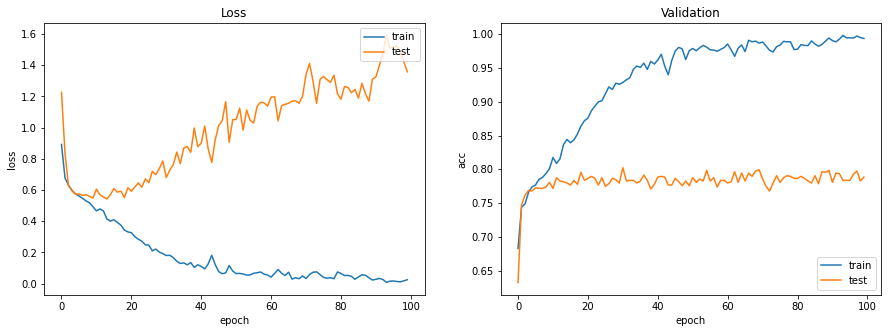

In [83]:
plot_loss_acc(model_history)
# Evaluamos contra test
score = modelA.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

In [ ]:
# import sklearn.metrics as metrics

# test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)
# predictions = classifier.predict_generator(test_set, steps=test_steps_per_epoch)
# predicted_classes = np.argmax(predictions, axis=1)

# true_classes = test_set.classes
# class_labels = list(test_set.class_indices.keys())

# report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report)

Probamos con modelo B

In [84]:
modelB = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
95/95 [==============================] - 3s 13ms/step - loss: 2.8268 - accuracy: 0.1942 - val_loss: 2.4456 - val_accuracy: 0.4437
Epoch 2/100
95/95 [==============================] - 1s 8ms/step - loss: 2.4290 - accuracy: 0.4284 - val_loss: 2.2593 - val_accuracy: 0.5504
Epoch 3/100
95/95 [==============================] - 1s 8ms/step - loss: 2.2119 - accuracy: 0.5072 - val_loss: 2.1174 - val_accuracy: 0.5781
Epoch 4/100
95/95 [==============================] - 1s 8ms/step - loss: 2.0555 - accuracy: 0.5345 - val_loss: 2.0085 - val_accuracy: 0.5958
Epoch 5/100
95/95 [==============================] - 1s 8ms/step - loss: 1.9282 - accuracy: 0.5800 - val_loss: 1.9171 - val_accuracy: 0.6018
Epoch 6/100
95/95 [==============================] - 1s 8ms/step - loss: 1.8317 - accuracy: 0.5806 - val_loss: 1.8403 - val_accuracy: 0.6166
Epoch 7/100
95/95 [==============================] - 1s 8ms/step - loss: 1.7655 - accuracy: 0.5904 - val_loss: 1.7769 - val_accuracy: 0.6393
Epoch 8/100


32/32 [==============================] - 0s 2ms/step - loss: 0.9437 - accuracy: 0.7520
Loss: 0.9436826705932617 
Accuracy: 75.19763112068176%


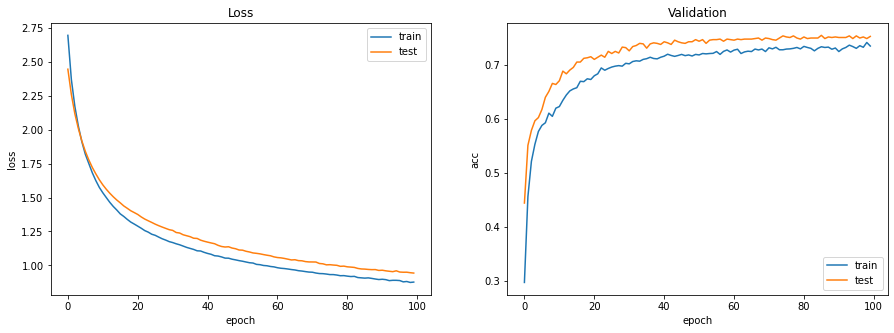

In [85]:
plot_loss_acc(model_history1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **PRUEBA 2: TESS + SAVEE**

In [86]:
savee_tess_dataset = datasetSAVEE.append(datasetTESS, ignore_index=True)
savee_tess_dataset = shuffle(savee_tess_dataset)
print("El nuevo dataframe tiene {} filas".format(len(savee_tess_dataset)))
savee_tess_dataset.head()

El nuevo dataframe tiene 3280 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
637,sad,-510.334351,70.392181,9.745888,26.842993,11.745151,20.425240,-24.863680,-9.029064,-22.670057,10.334230,-16.237906,10.448737,-6.454833,8.925146,-1.287253,-1.130406,1.360410,5.392533,3.845614,-6.088749,6.018774,0.454183,-1.299143,-0.605627,-8.349146,2.301697,-1.106400,-0.524050,0.836958,3.121175,5.696411,10.021482,6.794494,4.746070,7.358126,5.022173,7.890609,13.437910,11.815437,14.206939
655,sad,-538.357422,98.463135,29.502287,21.660967,15.271343,20.184244,-6.852172,-6.090780,-15.698928,4.030519,-15.446465,8.092417,-6.217247,4.571503,4.428746,-2.891979,-1.512002,3.445575,0.900727,-4.466614,2.073665,-3.452018,-3.194204,-0.202490,-6.837798,3.521023,-3.313960,0.683616,3.078632,10.079254,10.857882,13.743055,7.671250,4.093705,5.461768,3.605390,12.647918,14.460094,11.611190,9.603730
1237,sad,-382.114624,64.155983,26.742197,33.550068,-10.647670,16.407703,-13.662893,-5.873793,-6.649907,-0.335368,-11.796748,7.655837,-11.001994,12.155694,-13.474528,2.295565,-2.307993,-2.749547,-9.509460,-0.544002,-8.133907,-5.199031,-6.359110,0.201707,-3.855147,7.212991,2.690133,3.043985,2.513073,-0.476400,0.254465,9.609739,5.941122,6.744577,1.492931,0.386529,1.485051,3.741657,6.974833,5.472480
2636,disgust,-476.700897,91.397881,8.905907,1.676017,3.645423,9.743506,-11.389336,4.310838,-25.428411,3.543939,-17.487747,7.710441,-3.727219,3.241723,-2.983268,5.455729,-4.630273,1.873875,0.399473,1.844922,-0.640816,-2.594758,-3.644584,0.692002,-2.756605,3.034041,0.829400,1.462031,0.231325,1.409681,-0.380205,2.011659,1.714324,3.778357,5.985891,2.935180,8.357633,8.612011,15.440845,16.757879
2033,neutral,-495.340912,94.823067,15.062559,2.390880,-7.703606,11.210112,-7.134758,-4.483222,-20.042652,3.211141,-19.812994,4.694833,-8.729405,9.104014,3.872749,7.276460,-3.159242,7.418011,-3.430910,-4.233323,4.402491,1.169931,-4.707812,-1.475224,-10.407285,-0.758325,-5.615266,0.010377,-1.422346,-2.857815,-7.105725,-6.451050,-1.013472,11.818830,31.006689,31.914423,40.321930,27.721420,9.339764,-0.117169


In [87]:
savee_tess_dataset = savee_tess_dataset.dropna()
print(class_distribution = savee_tess_dataset['emotion'].value_counts())

neutral     520
happy       460
fear        460
disgust     460
angry       460
surprise    460
sad         460
Name: emotion, dtype: int64


In [88]:
X_train, X_test, Y_train, Y_test = dataset_splitted(savee_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (2460, 40, 1) y clases: (2460, 7)
Dimensiones del conjunto de test. Datos: (820, 40, 1) y clases: (820, 7)


Probamos el modelo A

In [89]:
model = model_A(X_train, Y_train.shape[1])
model_history2 = model.fit(X_train, Y_train, 
                        batch_size=32, 
                        epochs=100, 
                        validation_data=(X_test, Y_test))

Epoch 1/100
77/77 [==============================] - 7s 70ms/step - loss: 0.9288 - accuracy: 0.6964 - val_loss: 1.1404 - val_accuracy: 0.7659
Epoch 2/100
77/77 [==============================] - 5s 64ms/step - loss: 0.3778 - accuracy: 0.8683 - val_loss: 0.8211 - val_accuracy: 0.8537
Epoch 3/100
77/77 [==============================] - 5s 63ms/step - loss: 0.3460 - accuracy: 0.8638 - val_loss: 0.5037 - val_accuracy: 0.8598
Epoch 4/100
77/77 [==============================] - 5s 63ms/step - loss: 0.3225 - accuracy: 0.8835 - val_loss: 0.3724 - val_accuracy: 0.8659
Epoch 5/100
77/77 [==============================] - 5s 63ms/step - loss: 0.2953 - accuracy: 0.8909 - val_loss: 0.3485 - val_accuracy: 0.8610
Epoch 6/100
77/77 [==============================] - 5s 64ms/step - loss: 0.2607 - accuracy: 0.9002 - val_loss: 0.3297 - val_accuracy: 0.8646
Epoch 7/100
77/77 [==============================] - 5s 63ms/step - loss: 0.2401 - accuracy: 0.9094 - val_loss: 0.3217 - val_accuracy: 0.8854
Epoch 

52/52 [==============================] - 0s 7ms/step - loss: 0.9474 - accuracy: 0.8646
Loss: 0.9473899006843567 
Accuracy: 86.46341562271118%


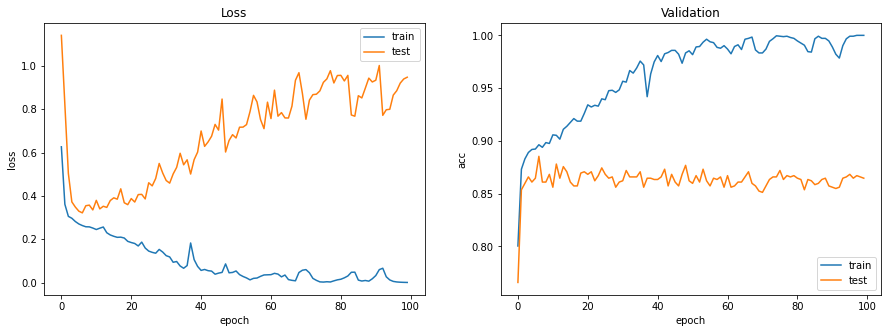

In [90]:
plot_loss_acc(model_history2)
# Evaluamos contra test
score = model.evaluate(X_test, Y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

Probamos el modelo B

In [93]:
modelB = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history2_1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
77/77 [==============================] - 2s 13ms/step - loss: 3.0197 - accuracy: 0.2185 - val_loss: 2.5504 - val_accuracy: 0.5085
Epoch 2/100
77/77 [==============================] - 1s 8ms/step - loss: 2.5416 - accuracy: 0.4894 - val_loss: 2.3508 - val_accuracy: 0.6378
Epoch 3/100
77/77 [==============================] - 1s 8ms/step - loss: 2.2961 - accuracy: 0.6002 - val_loss: 2.1976 - val_accuracy: 0.6866
Epoch 4/100
77/77 [==============================] - 1s 8ms/step - loss: 2.1220 - accuracy: 0.6422 - val_loss: 2.0688 - val_accuracy: 0.7098
Epoch 5/100
77/77 [==============================] - 1s 8ms/step - loss: 1.9680 - accuracy: 0.6810 - val_loss: 1.9627 - val_accuracy: 0.7415
Epoch 6/100
77/77 [==============================] - 1s 8ms/step - loss: 1.8580 - accuracy: 0.7205 - val_loss: 1.8737 - val_accuracy: 0.7634
Epoch 7/100
77/77 [==============================] - 1s 8ms/step - loss: 1.7487 - accuracy: 0.7250 - val_loss: 1.7941 - val_accuracy: 0.7671
Epoch 8/100


26/26 [==============================] - 0s 2ms/step - loss: 0.7409 - accuracy: 0.8500
Loss: 0.7408953309059143 
Accuracy: 85.00000238418579%


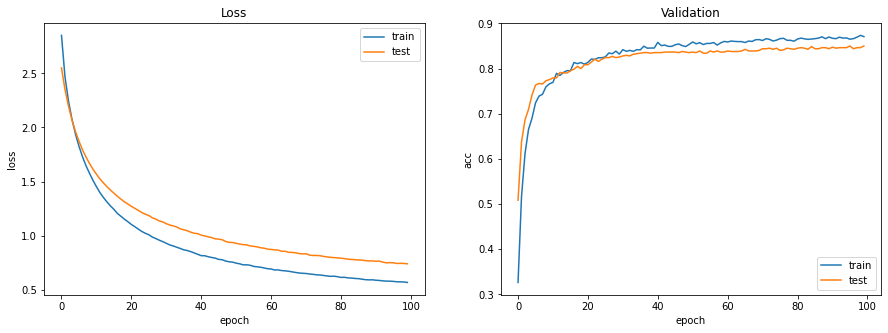

In [94]:
plot_loss_acc(model_history2_1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **PRUEBA RAVDESS + TESS + SAVEE**

In [95]:
# datasetRAVDESS
ravdess_savee_tess_dataset = savee_tess_dataset.append(datasetRAVDESS, ignore_index=True)
print("El nuevo dataframe tiene {} filas".format(len(ravdess_savee_tess_dataset)))
ravdess_savee_tess_dataset = shuffle(ravdess_savee_tess_dataset)
ravdess_savee_tess_dataset.head()

El nuevo dataframe tiene 4720 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
2710,surprise,-343.009125,47.728050,-18.101221,15.672547,-17.643803,-2.825111,-11.073112,-1.101778,-12.526596,7.310831,-14.354833,12.690731,-10.323326,7.834434,4.029524,0.838594,6.179397,5.122398,-0.378506,4.698691,-1.845964,2.911979,-2.786006,-0.349526,-0.155819,-0.646451,3.063614,2.764543,5.639046,6.036382,4.589956,7.792465,4.245055,3.228094,4.437760,2.960326,5.161386,2.871402,3.274293,2.151511
851,angry,-628.329895,123.768265,30.416164,50.389133,20.170723,-6.848425,-9.911340,1.979993,-9.450617,-6.825207,-0.419289,-4.543948,2.588768,3.603163,-1.162288,2.603070,3.694514,-1.234108,3.865354,7.100297,0.316184,-2.152087,4.058671,-0.245465,-1.277820,3.877745,2.377909,-0.778964,-0.779558,2.739792,1.814172,0.325780,0.517919,0.448338,0.313561,0.551691,1.454446,1.277957,-0.510721,0.456444
1572,surprise,-358.773621,62.006237,-14.479932,10.154110,-21.504757,-4.459529,-14.101966,-6.540182,-25.214005,4.594133,-18.506142,13.531118,-10.606586,8.555861,3.072385,0.918415,3.851475,8.187381,-5.495734,6.484674,-2.533552,0.840460,-2.227433,0.984195,-1.818566,0.809642,0.561838,2.443123,2.848465,7.444236,5.350684,5.982666,4.882818,5.525452,6.524957,5.200971,7.019897,4.697382,6.426716,2.583217
2250,happy,-342.933228,28.401171,-7.919914,43.771530,-13.230096,-1.025375,-11.346963,-5.110985,-9.960404,-4.285517,-12.670207,13.479669,-15.791413,9.603078,-4.291245,-1.225752,3.360604,1.365148,-4.328167,4.580448,-6.564611,6.661270,7.007147,9.029813,5.303141,-0.724641,0.706455,5.083240,10.489633,8.626203,0.864739,1.113624,1.339045,3.780848,3.428395,0.891259,-2.046996,-3.970856,-1.978914,-0.569650
3180,neutral,-422.093292,86.969231,-12.197537,28.954702,-12.365367,3.422497,-8.146502,-5.612322,-13.906979,10.528356,-17.825954,13.276339,-9.012196,8.035703,-5.637211,-3.949583,1.602223,-0.095865,-11.934770,0.715248,-5.754320,-5.512121,-8.275011,-4.820413,-6.280603,-1.894907,-3.640364,-1.261822,-8.284989,-3.409828,-5.609682,11.082355,22.979973,34.469868,37.855995,23.964245,11.067539,-6.527454,-3.317617,2.542051


In [97]:
ravdess_savee_tess_dataset = ravdess_savee_tess_dataset.dropna()
print(ravdess_savee_tess_dataset['emotion'].value_counts())

happy       652
fear        652
disgust     652
angry       652
surprise    652
sad         652
neutral     616
Name: emotion, dtype: int64


In [98]:
X_train, X_test, Y_train, Y_test = dataset_splitted(ravdess_savee_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (3396, 40, 1) y clases: (3396, 7)
Dimensiones del conjunto de test. Datos: (1132, 40, 1) y clases: (1132, 7)


Probamos con el modelo A

In [100]:
modelA = model_A(X_train, Y_train.shape[1])
model_history3 = modelA.fit(X_train, Y_train, 
                        batch_size=32, 
                        epochs=100, 
                        validation_data=(X_test, Y_test))

Epoch 1/100
107/107 [==============================] - 8s 67ms/step - loss: 1.2469 - accuracy: 0.5483 - val_loss: 1.2823 - val_accuracy: 0.6793
Epoch 2/100
107/107 [==============================] - 7s 64ms/step - loss: 0.8145 - accuracy: 0.6974 - val_loss: 0.9300 - val_accuracy: 0.6811
Epoch 3/100
107/107 [==============================] - 7s 63ms/step - loss: 0.7845 - accuracy: 0.6991 - val_loss: 0.8105 - val_accuracy: 0.6988
Epoch 4/100
107/107 [==============================] - 7s 64ms/step - loss: 0.7564 - accuracy: 0.7123 - val_loss: 0.7563 - val_accuracy: 0.6996
Epoch 5/100
107/107 [==============================] - 7s 64ms/step - loss: 0.7220 - accuracy: 0.7181 - val_loss: 0.7586 - val_accuracy: 0.6996
Epoch 6/100
107/107 [==============================] - 7s 64ms/step - loss: 0.6608 - accuracy: 0.7431 - val_loss: 0.7412 - val_accuracy: 0.6961
Epoch 7/100
107/107 [==============================] - 7s 64ms/step - loss: 0.6661 - accuracy: 0.7391 - val_loss: 0.7601 - val_accuracy:

71/71 [==============================] - 1s 7ms/step - loss: 1.9535 - accuracy: 0.7111
Loss: 1.9535104036331177 
Accuracy: 71.11307382583618%


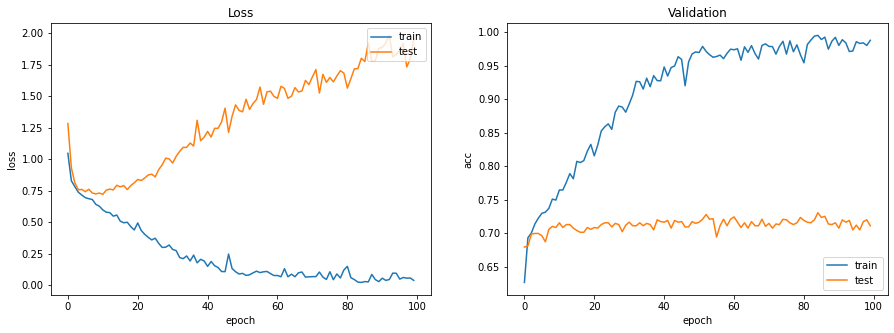

In [101]:
plot_loss_acc(model_history3)
# Evaluamos contra test
score = modelA.evaluate(X_test, Y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

Probamos el modelo B

In [102]:
modelB = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history3_1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
107/107 [==============================] - 3s 15ms/step - loss: 2.8469 - accuracy: 0.2662 - val_loss: 2.4720 - val_accuracy: 0.4090
Epoch 2/100
107/107 [==============================] - 1s 8ms/step - loss: 2.4594 - accuracy: 0.4261 - val_loss: 2.2878 - val_accuracy: 0.4947
Epoch 3/100
107/107 [==============================] - 1s 8ms/step - loss: 2.2517 - accuracy: 0.4645 - val_loss: 2.1513 - val_accuracy: 0.5177
Epoch 4/100
107/107 [==============================] - 1s 8ms/step - loss: 2.1111 - accuracy: 0.4780 - val_loss: 2.0418 - val_accuracy: 0.5565
Epoch 5/100
107/107 [==============================] - 1s 8ms/step - loss: 1.9998 - accuracy: 0.5110 - val_loss: 1.9567 - val_accuracy: 0.5663
Epoch 6/100
107/107 [==============================] - 1s 8ms/step - loss: 1.8971 - accuracy: 0.5314 - val_loss: 1.8846 - val_accuracy: 0.5786
Epoch 7/100
107/107 [==============================] - 1s 8ms/step - loss: 1.8178 - accuracy: 0.5453 - val_loss: 1.8255 - val_accuracy: 0.584

36/36 [==============================] - 0s 2ms/step - loss: 1.1214 - accuracy: 0.6731
Loss: 1.121447205543518 
Accuracy: 67.31448769569397%


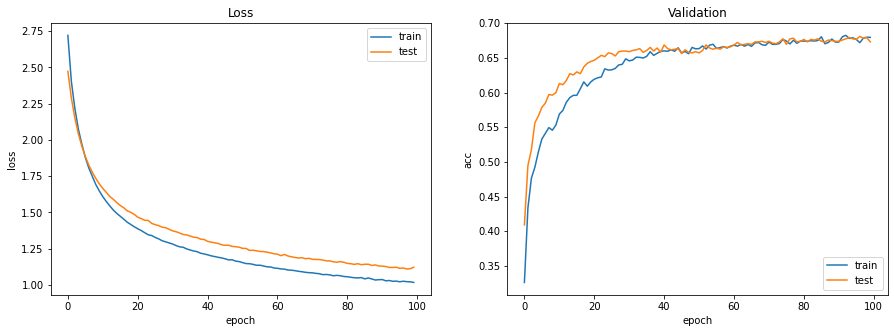

In [103]:
plot_loss_acc(model_history3_1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))